In [1]:
import os
import json
from tqdm import tqdm
from tensorflow import keras
from IPython.display import clear_output
from collections import Counter
import time

import matplotlib.pyplot as plt
import numpy as np


from pathlib import Path

In [2]:
# Path(os.getcwd()+"\output\cnn_models").mkdir(parents=True, exist_ok=True)

# Load input data

* data: Tabular data + ground truth
* dict_col_candidate_classes: a dictionary with filename_columns and in each of the an array of [(candidate_type, candidate_entity, original_cell_value, rank)]
* type_neighours_pos_neg_samples: a dictionary that is used to train the classifiers so for each candidate class we have the neighbouring classes, positive samples from the KG and positive and negative samples from the tabular data

# only consider candidate classes between columns that have links

In [3]:
# Load the dictionary with the lookup results for each cell value in the tabular data
def load_json(data_json):
    with open(data_json) as json_file:
        return json.load(json_file)

In [4]:
output_folder = "output\\"
cnn_model_directory = os.getcwd()+'\\output\\cnn_models'


data = load_json(output_folder+'data.json')

dict_col_candidate_classes = load_json(output_folder+'dict_col_candidate_classes.json')


# try:
#     type_neighours_pos_neg_samples = load_json(output_folder+'type_neighours_pos_neg_samples.json')
# except:
#     pass

# try:
#     dict_cand = load_json(output_folder+'dict_cand.json')
# except:
#     pass

# Assess lookup efficiency

In this step, provided that we have the ground truth, we asses if the expected class is in the top x of the retrieved candidate classes.

In [5]:
from rdflib import Graph
from SPARQLWrapper import SPARQLWrapper, JSON, N3
from pprint import pprint
import requests
import xml.etree.ElementTree as ET

In [6]:
def dbo_sparql_results(query_string):
    
    classes = list([])
    dbo_prefix = 'http://dbpedia.org/ontology/'
    
    
    sparql = SPARQLWrapper('https://dbpedia.org/sparql')
    sparql.setQuery(query_string)
    
    try:
        sparql.setReturnFormat(JSON)
        qres = sparql.query().convert()
        for entity_class in qres['results']['bindings']:
            if dbo_prefix in entity_class[list(qres['results']['bindings'][0].keys())[0]]['value']:
                candicate_class = entity_class[list(qres['results']['bindings'][0].keys())[0]]['value'].split(dbo_prefix)[1]
                classes.append(candicate_class)
    except:
        pass
    
    return classes

def get_dbo_subclass(superClass):
    
    query_string = f'''
    SELECT distinct ?subClass 
    WHERE {{ ?subClass rdfs:subClassOf dbo:{superClass}. }}
    '''
    return dbo_sparql_results(query_string)


def get_dbo_superclass(subclass):
    
    query_string = f'''
    SELECT distinct ?superClass 
    WHERE {{ dbo:{subclass} rdfs:subClassOf ?superClass . }}
    '''
    
    return dbo_sparql_results(query_string)


def get_dbo_superclasses(subclass):
    classes = list([])
    
    try:
        parent = get_dbo_superclass(subclass)
    except:
        return []
    
    while len(parent) > 0:
        classes.append(parent[0])
        parent = get_dbo_superclass(parent[0])
    return classes

In [7]:
get_dbo_superclass('Film')

['Work']

In [8]:
def get_column_candidate_classes(dict_col_candidate_classes,filename,col,limit = -1):
    if limit >= 0:
        candidate_list = Counter([i[0] for i in dict_col_candidate_classes[filename][col]]).most_common()[:limit]
    else:
        candidate_list = Counter([i[0] for i in dict_col_candidate_classes[filename][col]]).most_common()
#     return [x[0] for x in candidate_list]
    return candidate_list

dict_cand = dict()

total = 0
for filename in dict_col_candidate_classes:
    dict_cand[filename] = dict()
    for col in dict_col_candidate_classes[filename]:
        dict_cand[filename][col] = dict()
        dict_cand[filename][col]['class_without_hr'] = get_column_candidate_classes(dict_col_candidate_classes,filename, col)
        total+=1

In [9]:
# dict_cand

In [25]:
import pandas as pd

def lookup_vote_rank_weighted(dict_col_candidate_classes,rank_threshold=1, weighted = True):
    df_entities = pd.DataFrame()

    for filename in dict_col_candidate_classes:
        for col in dict_col_candidate_classes[filename]:
            df_entities = df_entities.append(pd.DataFrame([[filename,col,x[0], x[1], x[2], x[3]] for x in dict_col_candidate_classes[filename][col]], columns=['filename', 'col','type', 'entity', 'cell_value', 'rank']))

    df_entities = df_entities[df_entities['rank'] <= rank_threshold]
    # temp = df_entities.groupby(by=["filename", "col", "type"]).count()["entity"].reset_index().sort_values(by=['filename', 'col', 'entity'],ascending=False)

    df = df_entities
    if weighted == True:
        df['weighted_rank'] = df.apply(lambda x : 1/x['rank'], axis=1)
    else: df['weighted_rank'] = df.apply(lambda x : 1, axis=1)
    temp = df.groupby(by=["filename", "col", "type"]).sum()["weighted_rank"].reset_index().sort_values(by=['filename', 'col', 'weighted_rank'],ascending=False)




    dict_candidate = dict()
    for filename in list(temp.filename.unique()):
        dict_candidate[filename] = dict()
        for col in list(temp[temp.filename == filename].col.unique()):
            total = temp[(temp.filename==filename) & (temp.col == col)].sum().weighted_rank
            df = temp[(temp.filename==filename) & (temp.col == col)].copy()
            df['vote_pct'] = df.apply(lambda x : x.weighted_rank *100 / total, axis=1)
            dict_candidate[filename][col] = dict()
            dict_candidate[filename][col]['class_without_hr'] = list(df[['type','weighted_rank','vote_pct']].to_records(index=False))
    return dict_candidate

On top of having a list of all candidate classes that appear in a column, the next step is to remove classes that are higher up in the list if at least one of their subclasses also appears in the list.
This approach seems to improve the precision (i.e. the top classes are more relevant) but decrease the recall

In [53]:
dict_candidate = lookup_vote_rank_weighted(dict_col_candidate_classes,5,False)

(1, (18.03, 22.49))
(2, (32.34, 40.89))
(3, (48.88, 59.11))
(4, (60.78, 66.82))
(5, (65.43, 71.28))
(6, (79.74, 81.6))
(7, (81.04, 82.53))
(8, (82.71, 83.36))
(9, (82.9, 83.64))
(10, (82.9, 83.64))
(11, (82.9, 83.64))
(12, (82.9, 83.64))
(13, (83.27, 83.83))
(14, (83.27, 83.83))
(15, (83.64, 84.01))


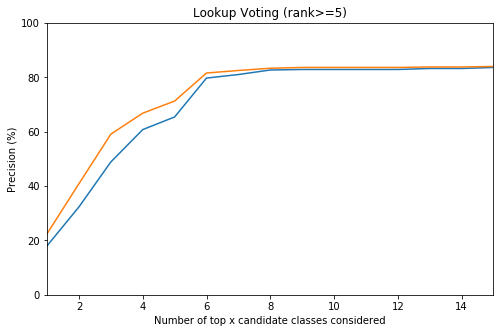

In [54]:
results = []

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,16):
    (x,y) = (i, lookup_assessment_considering_hr(dict_candidate, i))
    print((x,y))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.ylabel("Precision (%)")
plt.xlabel("Number of top x candidate classes considered")
plt.title("Lookup Voting (rank>=5)")
plt.axis(ymin=0, ymax=100, xmin=1, xmax=15)

plt.show()
results_top1_weighted = results

In [55]:
for i in results:
    print(f"{i[0]}:{i[1][0]} ({i[1][1]})")

1:18.03 (22.49)
2:32.34 (40.89)
3:48.88 (59.11)
4:60.78 (66.82)
5:65.43 (71.28)
6:79.74 (81.6)
7:81.04 (82.53)
8:82.71 (83.36)
9:82.9 (83.64)
10:82.9 (83.64)
11:82.9 (83.64)
12:82.9 (83.64)
13:83.27 (83.83)
14:83.27 (83.83)
15:83.64 (84.01)


In [ ]:
# remove the type Agent as it is too generic and appears quite frequently

for file in dict_candidate:
    for col in dict_candidate[file]:
        dict_candidate[file][col]['class_without_hr'] = [x for x in dict_candidate[file][col]['class_without_hr'] if x[0] != 'Agent']

In [ ]:
results = []

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,16):
    (x,y) = (i, lookup_assessment_considering_hr(dict_candidate, i))
    print((x,y))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.ylabel("Precision (%)")
plt.xlabel("Number of top x candidate classes considered")
plt.title("Lookup Voting (rank>=5)")
plt.axis(ymin=0, ymax=100, xmin=1, xmax=15)

plt.show()
results_top1_weighted = results

In [ ]:
for i in results:
    print(f"{i[0]}:{i[1][0]} ({i[1][1]})")

In [ ]:
new = list()

for file in dict_candidate:
    for col in dict_candidate[file]:
        new.append([file,col,"http://dbpedia.org/ontology/"+dict_candidate[file][col]['class_without_hr'][0][0]])

temp_results = pd.DataFrame(new, columns=['file','column','class'])

In [ ]:
temp_results.to_csv('lookup_rank1_pred_csv.csv',index = False)

In [ ]:
df

In [ ]:
with open(('output/dict_candidate_rank1_2019-%s.json' % time.strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(dict_candidate, fp)

In [ ]:
from tqdm import tqdm

for filename in tqdm(dict_cand):
    for col in dict_cand[filename]:
        dict_cand[filename][col]['class_with_hr'] = list([])
        for cls in dict_cand[filename][col]['class_without_hr']:
            if len([value for value in get_dbo_subclass(cls) if value in dict_cand[filename][col]['class_without_hr']]) == 0:
                dict_cand[filename][col]['class_with_hr'].append(cls)
                
with open(('output/dict_cand-%s.json' % time.strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(dict_cand, fp)

# Experiments:
 1. Top X without repetition of cell values, without checking parent child relationships
 2. Top x without repetition of cell values, having removed candidate classes for which at list one subclass also appears in the list of candidate classes
 3. Top x with repetition of cell values. This means if a value appears multiple times in a column then the cancidate class will get more that one votes from that cell value

In [18]:
def lookup_assessment(dict_cand, threshold = 10000):
    found = 0
    found_with = 0
    total_columns = 0

    for file in dict_cand:
        for col in dict_cand[file]:
            candidate_class_without_hr = [x[0] for x in dict_cand[file][col]['class_without_hr'][:threshold]]
#             candidate_class_with_hr = dict_cand[file][col]['class_with_hr'][:threshold]
            actual_cls = data[file]['gt'][col]
            if actual_cls in candidate_class_without_hr:
                found+=1
#             if actual_cls in candidate_class_with_hr:
#                 found_with+=1
            total_columns+=1
    return (round(100*found/total_columns,2),round(100*found_with/total_columns,2))



def lookup_assessment_considering_hr(dict_cand, threshold = 10000):
    """
    This is a function that considers half a point (instead of a whole point) in case the predicted class is a parent of the expected type
    """
    found = 0
    found_with = 0
    parent_found = 0
    total_columns = 0

    for file in dict_cand:
        for col in dict_cand[file]:
            candidate_class_without_hr = [x[0] for x in dict_cand[file][col]['class_without_hr'][:threshold]]
#             candidate_class_with_hr = dict_cand[file][col]['class_with_hr'][:threshold]
            actual_cls = data[file]['gt'][col]
            if actual_cls in candidate_class_without_hr:
                found+=1
                parent_found += 1
            # else we give half a point in case the predicted value is in the hierarchy (i.e. parent) of the actual value
            else:
                parents_of_expected_type = get_dbo_superclass(actual_cls)
                intersection = [value for value in parents_of_expected_type if value in candidate_class_without_hr]
                if len(intersection) > 0:
                    parent_found += 0.5
                    
#             if actual_cls in candidate_class_with_hr:
#                 found_with+=1
            total_columns+=1
    return (round(100*found/total_columns,2),round(100*parent_found/total_columns,2))

In [ ]:
dict_candidate['58891288_0_1117541047012405958']['1'].keys()

In [ ]:
results = []

# first we calculate the max number of candidates across all the columns in the tabular data so we cap the range
# max_cand = 0
# for file in dict_col_candidate_classes_rank2:
#     for col in dict_col_candidate_classes_rank2[file]:
        
#         candidate_cls = set()
#         for element in dict_col_candidate_classes_rank2[file][col]:
#             candidate_cls.add(element[0])
#         if len(candidate_cls) > max_cand:
#             max_cand = len(candidate_cls)

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,16):
    (x,y) = (i, lookup_assessment_considering_hr(dict_candidate, i))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots()
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.show()
results

In [ ]:
results = []

# first we calculate the max number of candidates across all the columns in the tabular data so we cap the range
# max_cand = 0
# for file in dict_col_candidate_classes_rank2:
#     for col in dict_col_candidate_classes_rank2[file]:
        
#         candidate_cls = set()
#         for element in dict_col_candidate_classes_rank2[file][col]:
#             candidate_cls.add(element[0])
#         if len(candidate_cls) > max_cand:
#             max_cand = len(candidate_cls)

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,26):
    (x,y) = (i, lookup_assessment_considering_hr(dict_candidate, i))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots()
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.show()
results

In [ ]:
results = []

# first we calculate the max number of candidates across all the columns in the tabular data so we cap the range
max_cand = 0
for file in dict_col_candidate_classes_rank2:
    for col in dict_col_candidate_classes_rank2[file]:
        
        candidate_cls = set()
        for element in dict_col_candidate_classes_rank2[file][col]:
            candidate_cls.add(element[0])
        if len(candidate_cls) > max_cand:
            max_cand = len(candidate_cls)

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,16):
    (x,y) = (i, lookup_assessment_considering_hr(dict_cand, i))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots()
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.show()
results

In [ ]:
results = []

# first we calculate the max number of candidates across all the columns in the tabular data so we cap the range
max_cand = 0
for file in dict_col_candidate_classes:
    for col in dict_col_candidate_classes[file]:
        
        candidate_cls = set()
        for element in dict_col_candidate_classes[file][col]:
            candidate_cls.add(element[0])
        if len(candidate_cls) > max_cand:
            max_cand = len(candidate_cls)

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,10):
    (x,y) = (i, lookup_assessment(dict_cand, i))
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots()
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.show()
results

TF-IDF

In [56]:
import math
import pandas as pd

def lookup_vote_tfidf(dict_col_candidate_classes,threshold=1):
    
    dict_tfidf = dict()
    cls_terms = set()

    for file in dict_col_candidate_classes:
        for col in dict_col_candidate_classes[file]:
            key = 'file_%s_col_%s' % (file,col)
            temp = list()
            for cls in dict_col_candidate_classes[file][col]:
                if cls[3] <= threshold:
                    temp.append(cls[0])
            cls_terms = cls_terms | set(temp)
            dict_tfidf [key] = temp

    # Calculate Term Frequency
    dict_tf = dict()
    for t in cls_terms:
        dict_tf[t] = dict()
        for document in dict_tfidf:
            try: 
                dict_tf[t][document] = dict_tfidf[document].count(t) / len(dict_tfidf[document])
            except:
                dict_tf[t][document] = 0

    # Calculate Inverse Document Frequency
    dict_idf = dict()
    for t in cls_terms:
        count_document = 0
        for document in dict_tfidf:
            if dict_tfidf[document].count(t) > 0:
                count_document +=1
        dict_idf[t] = math.log(len(dict_tfidf)/(1+count_document))
        
    
    # Bring it all together to combine tf and idf
    dict_tf_idf_pred = dict()
    candidates_tfidf = list()

    for t in dict_tf:
        for d in dict_tf[t]:
            if abs(dict_tf[t][d]*dict_idf[t]) > 0:
                candidates_tfidf.append([d[5:d.find('_col_')], d[d.find('_col_')+5:],t,dict_tf[t][d],dict_idf[t],dict_tf[t][d]*dict_idf[t]])
                
    # Create a dataframe with the proposed candidates
    temp = pd.DataFrame(candidates_tfidf, columns=["filename","column","cls","tf","idf","tfidf"])
    
    #Sort the values to prep them for the assessment
    temp.sort_values(by=["filename", "column", "tfidf"], ascending=False, inplace=True)
    
    # and finally create the structure of the dictionary
    dict_candidate_with_tfidf = dict()
    for row in temp.iterrows():
        if row[1].filename not in dict_candidate_with_tfidf:
            dict_candidate_with_tfidf[row[1].filename] = dict()
        if row[1].column not in dict_candidate_with_tfidf[row[1].filename]:
            dict_candidate_with_tfidf[row[1].filename][row[1].column] = dict()
            dict_candidate_with_tfidf[row[1].filename][row[1].column]['class_without_hr'] = list()

        dict_candidate_with_tfidf[row[1].filename][row[1].column]['class_without_hr'].append((row[1].cls,row[1].tfidf))

    return dict_candidate_with_tfidf  

In [ ]:
# dict_candidate_with_tfidf = lookup_vote_tfidf(dict_col_candidate_classes,3)

# with open(('output/dictdict_candidate_with_tfidf_cand-%s.json' % time.strftime("%Y%m%d-%H%M%S")), 'w') as fp:
#         json.dump(dict_candidate_with_tfidf, fp)

1 (21.56, 24.35)
2 (42.94, 45.26)
3 (50.19, 51.12)
4 (54.28, 55.2)
5 (60.59, 61.52)
6 (63.2, 63.75)
7 (65.24, 65.61)
8 (65.8, 67.47)
9 (69.52, 70.35)
10 (70.45, 71.28)
11 (72.12, 72.86)
12 (74.54, 75.09)
13 (75.09, 75.65)
14 (75.84, 76.21)
15 (76.02, 76.39)


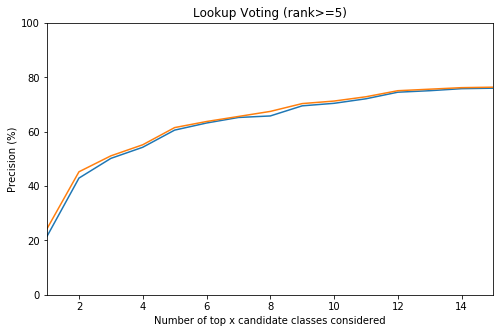

In [65]:
results = []
dict_candidate_with_tfidf = lookup_vote_tfidf(dict_col_candidate_classes,5)

# the we increase the size of top list one element at a time until we reac the cap...
for i in range(1,16):
    (x,y) = (i, lookup_assessment_considering_hr(dict_candidate_with_tfidf, i))
    print(x,y)
    results.append((x,y))

#... and plot the results
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([x[0] for x in results],[x[1] for x in results])
plt.ylabel("Precision (%)")
plt.xlabel("Number of top x candidate classes considered")
plt.title("Lookup Voting (rank>=5)")
plt.axis(ymin=0, ymax=100, xmin=1, xmax=15)

plt.show()

In [66]:
for i in results:
    print(f"{i[0]}:{i[1][0]} ({i[1][1]})")

1:21.56 (24.35)
2:42.94 (45.26)
3:50.19 (51.12)
4:54.28 (55.2)
5:60.59 (61.52)
6:63.2 (63.75)
7:65.24 (65.61)
8:65.8 (67.47)
9:69.52 (70.35)
10:70.45 (71.28)
11:72.12 (72.86)
12:74.54 (75.09)
13:75.09 (75.65)
14:75.84 (76.21)
15:76.02 (76.39)


In [ ]:
with open(('output/dict_cand-%s.json' % time.strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(dict_candidate_with_tfidf, fp)

In [ ]:
for i in results:
    print(f"{i[0]}:{i[1][0]} ({i[1][1]})")

In [ ]:
for i in results:
    print(f"{i[0]}:{i[1][0]} ({i[1][1]})")

In [ ]:
temp[(temp.filename=='29414811_6_8221428333921653560') &( temp.column=='3')]

In [ ]:
dict_candidate